### Import modules + Check GPU

In [15]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
from torchvision.io import read_image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
import time
from skimage import io
from tqdm import tqdm
import scipy.ndimage
from torch.utils.tensorboard import SummaryWriter

# for SSIM
import math

# for beta selection
import random

In [16]:
print("GPU available: {}".format(torch.cuda.is_available()))
print("Device: {}".format(torch.cuda.get_device_name(0)))

GPU available: True
Device: Tesla K80


### Data Generation

In [34]:
def isotropic_diffusion(img, niter=1, kappa=50, gamma=0.1, voxelspacing=None):

    # initialize output array
    out = np.array(img, dtype=np.float32, copy=True)

    # set default voxel spacing if not supplied
    if voxelspacing is None:
        voxelspacing = tuple([1.] * img.ndim)

    # initialize some internal variables
    deltas = [np.zeros_like(out) for _ in range(out.ndim)]

    
    time = 0
    
    results_pixels = []
    results_dIdt = []
    results_time = []
    
    results_pixels.append(out.astype(img.dtype))
    results_time.append(time)
    #results_dIdt.append(np.zeros_like(out))

    for iter in tqdm(range(niter)):
        # calculate the diffs
        for i in range(out.ndim):
            slicer = [slice(None, -1) if j == i else slice(None) for j in range(out.ndim)]
            diff_local = np.diff(out, axis=i)
            deltas[i][tuple(slicer)] = diff_local

        matrices = [delta for delta, spacing in zip(deltas, voxelspacing)]

        # second derivative
        for i in range(out.ndim):
            slicer = [slice(1, None) if j == i else slice(None) for j in range(out.ndim)]
            matrices[i][tuple(slicer)] = np.diff(matrices[i], axis=i)

        
        dIdt = np.sum(matrices, axis=0)
        #print(dIdt)
        
        # update the image
        out += gamma * (dIdt)
        time += gamma
        
        results_dIdt.append(dIdt.astype(img.dtype))
        if iter < niter - 1:
            results_pixels.append(out.astype(img.dtype))
            results_time.append(time)

    return results_pixels, results_dIdt, results_time

def get_mgrid(sidelen=256, dim=2):
    
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    
    return mgrid

class ImageFitting(Dataset):
    
    def __init__(self, img_path, niter):
        
        self.transform = Compose([
            Resize(256),
            ToTensor(),
            Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
        ])
        self.coords = get_mgrid()
        
        print("-----Generating Data-----")
        self.base_img = io.imread(img_path)
        self.imgs_pixels, self.imgs_dIdt, self.imgs_time = isotropic_diffusion(self.base_img, niter=niter, kappa=50, gamma=1/(niter+1))

        print("-----Finished-----")
        
        self.len = len(self.imgs_pixels)
        
    def __len__(self):
        
        return self.len
    
    def __getitem__(self, idx):

        image = self.imgs_pixels[idx]
        image = self.transform(Image.fromarray(image))
        
        pixels = image.permute(1, 2, 0).view(-1, 1)
        step_val = torch.full((self.coords.size(0),1), self.imgs_time[idx])

        model_input = torch.cat((self.coords, step_val), 1)
        
        # Compute gradient and laplacian       
        grads_x = scipy.ndimage.sobel(image.numpy(), axis=1).squeeze(0)[..., None]
        grads_y = scipy.ndimage.sobel(image.numpy(), axis=2).squeeze(0)[..., None]
        grads_x, grads_y = torch.from_numpy(grads_x), torch.from_numpy(grads_y)
                
        grads = torch.stack((grads_x, grads_y), dim=-1).view(-1, 2)
        laplace = scipy.ndimage.laplace(image.numpy()).squeeze(0)[..., None]
        laplace = torch.from_numpy(laplace).view(-1, 1)
        
        dIdt = torch.from_numpy(self.imgs_dIdt[idx])
        dIdt = dIdt.permute(0,1).view(-1)
        
        return model_input, {'pixels':pixels, 'grads':grads, 'laplace':laplace, 'dIdt':dIdt}

### Loss Calculation

In [32]:
def computeJacobianFull(x, outputs, create_graph):
    
    dy_dx = torch.autograd.grad(outputs=outputs, inputs=x, grad_outputs=torch.ones_like(outputs),
            retain_graph=True, create_graph=create_graph, allow_unused=True)[0]
    
    dy_dx = dy_dx.view(outputs.size(0), outputs.size(1), dy_dx.size(2))
    
    return dy_dx

def computeLaplaceFull(x, jacobian, create_graph):
    
    div = 0
    for j in range(jacobian.size(-1)):

        dy_dx2 = torch.autograd.grad(outputs=jacobian[:, :, j], inputs=x, grad_outputs=torch.ones_like(jacobian[:, :, j]),
            retain_graph=True, create_graph=create_graph)[0][..., j:j+1]

        div += dy_dx2

    return div

def calcLoss(coords, model_output, gt):
    
    pixel_loss = ((model_output - gt['pixels'])**2).mean()
    
    gradients = computeJacobianFull(coords, model_output, create_graph=True)
    grad_loss = ((gradients[:,:,:-1] - gt['grads']).pow(2).sum(-1)).mean()
    
    laplacian = computeLaplaceFull(coords, gradients[:,:,:-1], create_graph=False)
    laplacian_loss = ((laplacian - gt['laplace'])**2).mean()
    
    dIdt_loss = ((gradients[:,:,-1] - gt['dIdt'])**2).mean()
    
    pixel_ssim = mean_ssim(gt['pixels'][0].cpu().view(1, 256,256).detach(), model_output[0].cpu().view(1, 256,256).detach(), val_range=255)
    
    grad_ssim = mean_ssim(gt['grads'][0].norm(dim=-1).cpu().view(1, 256,256).detach(), gradients[0][:,:-1].norm(dim=-1).cpu().view(1, 256,256).detach(), val_range=255)
    
    laplacian_ssim = mean_ssim(gt['laplace'][0].cpu().view(1, 256,256).detach(), laplacian[0].cpu().view(1, 256,256).detach(), val_range=255)
    
    dIdt_ssim = mean_ssim(gt['dIdt'][0].cpu().view(1, 256,256).float().detach(), gradients[0][:,-1].cpu().view(1, 256,256).detach(), val_range=255)
    
    return pixel_loss, grad_loss, laplacian_loss, dIdt_loss, pixel_ssim, grad_ssim, laplacian_ssim, dIdt_ssim


### SSIM (Structural Similarity Index Measure)
original SSIM paper: https://www.cns.nyu.edu/pub/eero/wang03-reprint.pdf \
code source: https://github.com/pranjaldatta/SSIM-PyTorch \
explanation: https://medium.com/srm-mic/all-about-structural-similarity-index-ssim-theory-code-in-pytorch-6551b455541e

In [19]:
def gaussian(window_size=11, sigma=1.5):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """    
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

In [20]:
def create_window(window_size=11, channel=1):

    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    
    # Converting to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
     
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

    return window

In [21]:
# mean SSIM with SSIM applied locally over moving windows
# output = 1: the same image, output = 0 (or -1): very different
def mean_ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):

    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2
    
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret

In [22]:
# Helper functions to convert to Tensors
tensorify = lambda x: torch.Tensor(x.transpose((1, 0))).unsqueeze(0).float().div(255.0)

In [23]:
# ### Example Usage ###

# img_path_temp = 'original/cameraman.png'
# img1 = io.imread(img_path_temp)
# img2 = io.imread(img_path_temp)

# # Check SSIM score of True image vs False Image
# _img1 = tensorify(img1)
# _img2 = tensorify(img2)
# true_vs_false = mean_ssim(_img1, _img2, val_range=255)
# print("True vs False Image SSIM Score:", true_vs_false)

### SIREN Network Architecture

In [24]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

### ELU Network Architecture

In [25]:
class ELULayer(nn.Module):
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            nn.init.xavier_uniform_(self.linear.weight)
        
    def forward(self, input):
        return F.elu(self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.linear(input)
        return F.elu(intermediate), intermediate
    
    
class Base(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(ELULayer(in_features, hidden_features))

        for i in range(hidden_layers):
            self.net.append(ELULayer(hidden_features, hidden_features))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                nn.init.xavier_uniform_(final_linear.weight)
                
            self.net.append(final_linear)
        else:
            self.net.append(ELULayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

### Train Network

In [26]:
def train(net, writer, img_path, niter, total_epochs=50, lr=[1e-4], beta_0=1, beta_1=1, beta_2=1, beta_3=1, 
          cyclic=False, decay_exp=False, decay_multi=False):
    
    """Args:
        net: Network to Train
        writer: SummaryWriter for logging
        img_path: path to default state image
        niter: number of steps to apply diffusion (0 means only 1 image)
        total_epochs: number of epochs to train
        beta_0: constant for loss on pixel value
        beta_1: constant for loss on gradients
        beta_2: constant for loss on laplacian
        beta_3: constant for loss on pixel time derivative
        cyclic: CyclicLearning rate (allows better learning)"""
    
    
    image = ImageFitting(img_path=img_path, niter=niter)
    dataloader = DataLoader(image, batch_size=1, pin_memory=True, num_workers=0)

    net.cuda()

    epochs_til_summary = 10 #UPDATE ACCORDINGLY
    steps_til_summary = 5 #UPDATE ACCORDINGLY

    optim = torch.optim.Adam(lr=lr[0], params=net.parameters())
    
    if decay_multi:
        m = np.floor(total_epochs/4)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[m*1,m*2,m*3], gamma=0.1)
    
    if decay_exp:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)
    
    if cyclic:
        scheduler = torch.optim.lr_scheduler.CyclicLR(optim, base_lr=lr[1], max_lr=lr[0], step_size_up=250, cycle_momentum=False)
    
    print("-----Begin Training-----")
    for epoch in range(1, total_epochs + 1):
        
        epoch_loss = 0.0
        epoch_pixel_loss = 0.0
        epoch_grad_loss = 0.0
        epoch_laplacian_loss = 0.0
        epoch_dIdt_loss = 0.0
        
        epoch_pixel_ssim = 0.0
        epoch_grad_ssim = 0.0
        epoch_laplacian_ssim = 0.0
        epoch_dIdt_ssim = 0.0

        for step, batch in tqdm(enumerate(dataloader)):

            model_input = batch[0].cuda()
            gt = {key: value.cuda() for key, value in batch[1].items()}

            model_output, coords = net(model_input)   
            
            pixel_loss, grad_loss, laplacian_loss, dIdt_loss, pixel_ssim, grad_ssim, laplacian_ssim, dIdt_ssim = calcLoss(coords, model_output, gt)
            
            loss = beta_0 * pixel_loss + beta_1 * grad_loss + beta_2 * laplacian_loss + beta_3 * dIdt_loss
            
            epoch_loss += model_output.shape[0] * loss.item()
            epoch_pixel_loss += model_output.shape[0] * pixel_loss.item()
            epoch_grad_loss += model_output.shape[0] * grad_loss.item()
            epoch_laplacian_loss += model_output.shape[0] * laplacian_loss.item()
            epoch_dIdt_loss += model_output.shape[0] * dIdt_loss.item()

            epoch_pixel_ssim += model_output.shape[0] * pixel_ssim.item()
            epoch_grad_ssim += model_output.shape[0] * grad_ssim.item()
            epoch_laplacian_ssim += model_output.shape[0] * laplacian_ssim.item()
            epoch_dIdt_ssim += model_output.shape[0] * dIdt_ssim.item()

            if not epoch % epochs_til_summary and step % steps_til_summary == steps_til_summary - 1:

                pixel_output = model_output[0].view(1, -1, 256, 256)
                pixel_gt = gt['pixels'][0].view(1, -1, 256, 256)
                img_grid_pixel = torchvision.utils.make_grid(torch.cat((pixel_gt, pixel_output), 0), 2)
                img_grid_pixel = img_grid_pixel * 0.5 + 0.5
                writer.add_image('pixels', img_grid_pixel, epoch * len(dataloader) + step + 1)
                
                
                img_grad = computeJacobianFull(coords, model_output, create_graph=True)
                grad_output = img_grad[0,:,:-1].norm(dim=-1).view(1, -1, 256, 256)
                grad_gt = gt['grads'][0].norm(dim=-1).view(1, -1, 256, 256)
                img_grid_grad = torchvision.utils.make_grid(torch.cat((grad_gt, grad_output), 0), 2)
                writer.add_image('grads', img_grid_grad, epoch * len(dataloader) + step + 1)
                
                
                img_laplacian = computeLaplaceFull(coords, img_grad, create_graph=False)
                laplacian_output = img_laplacian[0].view(1, -1, 256, 256)
                laplacian_gt = gt['laplace'][0].view(1, -1, 256, 256)
                img_grid_laplacian = torchvision.utils.make_grid(torch.cat((laplacian_gt, laplacian_output), 0), 2)
                writer.add_image('laplacians', img_grid_laplacian, epoch * len(dataloader) + step + 1)
                
                dIdt_output = img_grad[0,:,-1].view(1, -1, 256, 256)
                dIdt_gt = gt['dIdt'][0].view(1, -1, 256, 256)
                img_grid_dIdt = torchvision.utils.make_grid(torch.cat((dIdt_gt, dIdt_output), 0), 2)
                writer.add_image('dIdt', img_grid_dIdt, epoch * len(dataloader) + step + 1)

                fig, axes = plt.subplots(2,4, figsize=(18,6))
                axes[0,0].imshow(gt['pixels'][0].cpu().view(256,256).detach().numpy())
                axes[0,1].imshow(gt['grads'][0].norm(dim=-1).cpu().view(256,256).detach().numpy())
                axes[0,2].imshow(gt['laplace'][0].cpu().view(256,256).detach().numpy())
                axes[0,3].imshow(gt['dIdt'][0].cpu().view(256,256).detach().numpy())
                axes[1,0].imshow(model_output[0].cpu().view(256,256).detach().numpy())
                axes[1,1].imshow(img_grad[0][:,:-1].norm(dim=-1).cpu().view(256,256).detach().numpy())
                axes[1,2].imshow(img_laplacian[0].cpu().view(256,256).detach().numpy())
                axes[1,3].imshow(img_grad[0][:,-1].cpu().view(256,256).detach().numpy())
                plt.show()

            optim.zero_grad()
            loss.backward()
            optim.step()

            if cyclic or decay_exp or decay_multi:
                scheduler.step()
        
        # logging epoch loss
        writer.add_scalar('epoch_loss/total', epoch_loss/len(image), epoch)
        writer.add_scalar('epoch_loss/pixel', epoch_pixel_loss/len(image), epoch)
        writer.add_scalar('epoch_loss/grad', epoch_grad_loss/len(image), epoch)
        writer.add_scalar('epoch_loss/laplacian', epoch_laplacian_loss/len(image), epoch)
        writer.add_scalar('epoch_loss/dIdt', epoch_dIdt_loss/len(image), epoch)
        print("epoch %d, Epoch loss: total %0.6f, pixel %0.6f, grad %0.6f, laplacian %0.6f, dIdt %0.6f" % (epoch, epoch_loss/len(image), epoch_pixel_loss/len(image), epoch_grad_loss/len(image), epoch_laplacian_loss/len(image), epoch_dIdt_loss/len(image)))
        
        # logging ssim loss
        writer.add_scalar('epoch_ssim/pixel', epoch_pixel_ssim/len(image), epoch)
        writer.add_scalar('epoch_ssim/grad', epoch_grad_ssim/len(image), epoch)
        writer.add_scalar('epoch_ssim/laplacian', epoch_laplacian_ssim/len(image), epoch)
        writer.add_scalar('epoch_ssim/dIdt', epoch_dIdt_ssim/len(image), epoch)
        print("Epoch SSIM: pixel %0.6f, grad %0.6f, laplacian %0.6f, dIdt %0.6f" % (epoch, epoch_pixel_ssim/len(image), epoch_grad_ssim/len(image), epoch_laplacian_ssim/len(image), epoch_dIdt_ssim/len(image)))
    
    writer.add_graph(net, model_input)
    print("-----Finished-----")
                

### Baselines

#### SIREN Baselines

-----Generating Data-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1338.15it/s]


-----Finished-----
-----Begin Training-----


10it [00:25,  2.55s/it]


epoch 1, Epoch loss: total 0.206069, pixel 0.206069, grad 9.824067, laplacian 604.107291, dIdt 17895.554590


10it [00:26,  2.61s/it]


epoch 2, Epoch loss: total 0.087270, pixel 0.087270, grad 15.148563, laplacian 9571.869775, dIdt 17902.813867


10it [00:26,  2.66s/it]


epoch 3, Epoch loss: total 0.109506, pixel 0.109506, grad 13.595884, laplacian 8474.436609, dIdt 17927.521582


10it [00:25,  2.59s/it]


epoch 4, Epoch loss: total 0.061582, pixel 0.061582, grad 19.580255, laplacian 26093.519922, dIdt 17880.685645


0it [00:00, ?it/s]

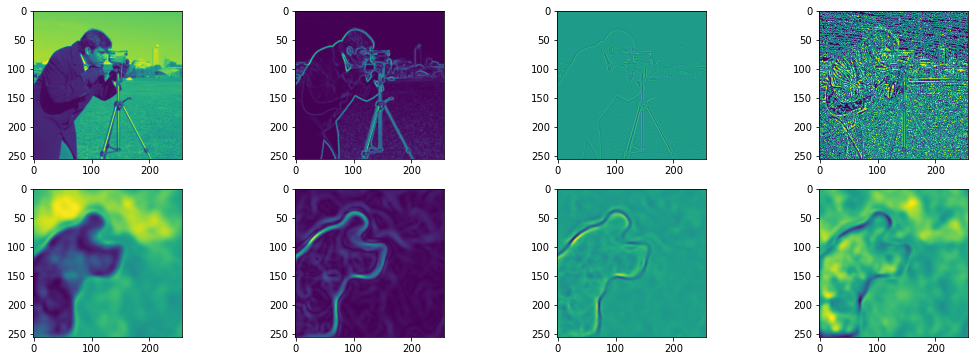

1it [00:04,  4.99s/it]

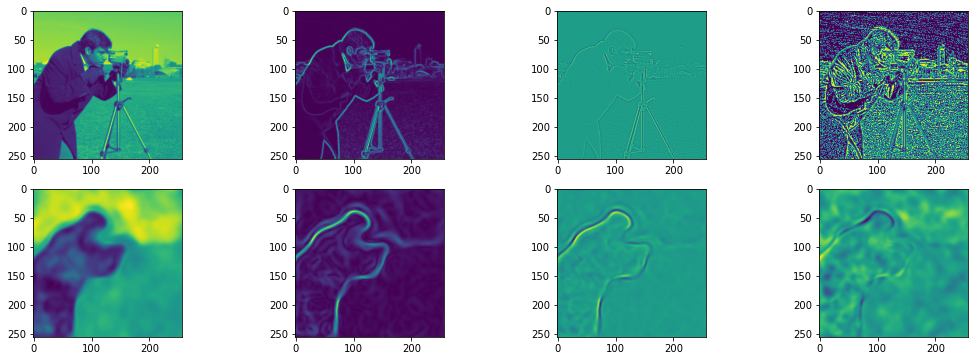

2it [00:09,  4.94s/it]

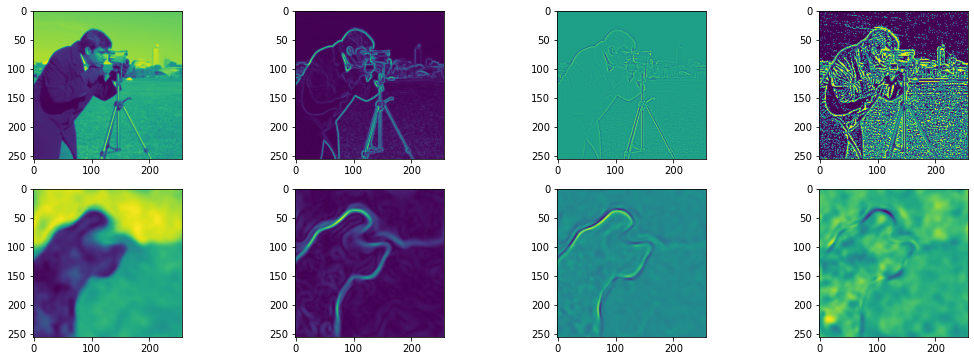

3it [00:15,  5.26s/it]

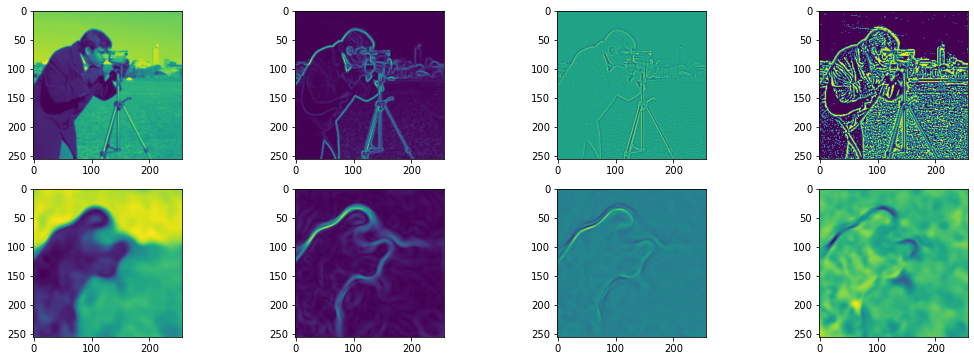

4it [00:20,  5.15s/it]

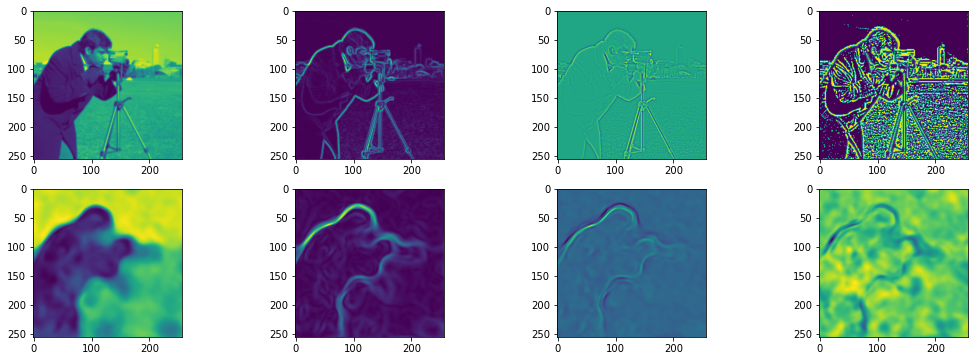

5it [00:25,  5.05s/it]

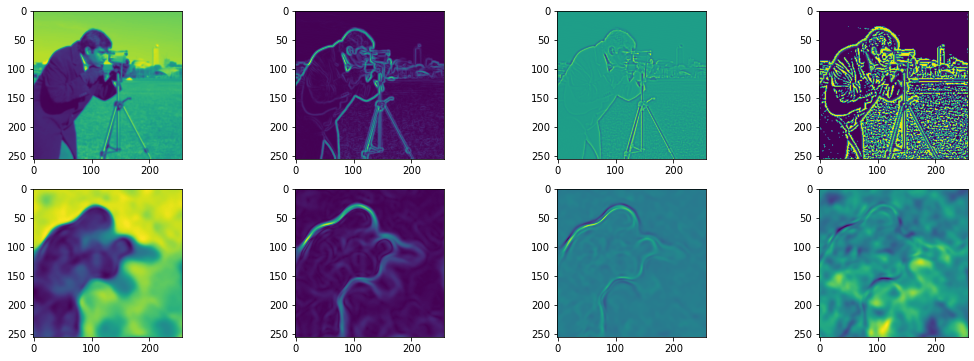

6it [00:30,  4.99s/it]

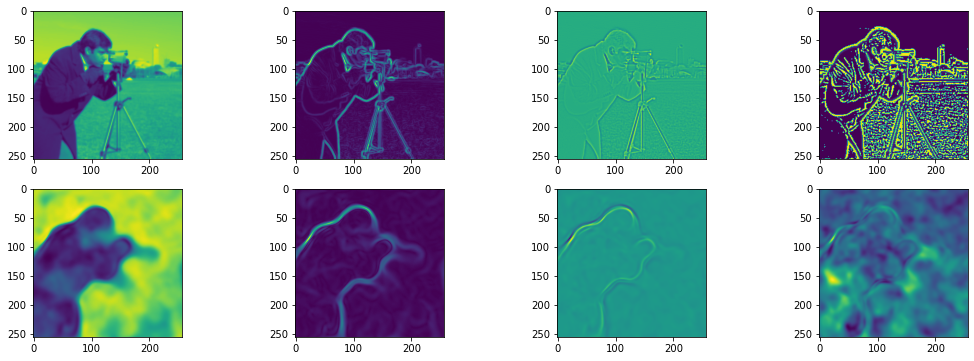

7it [00:35,  4.99s/it]

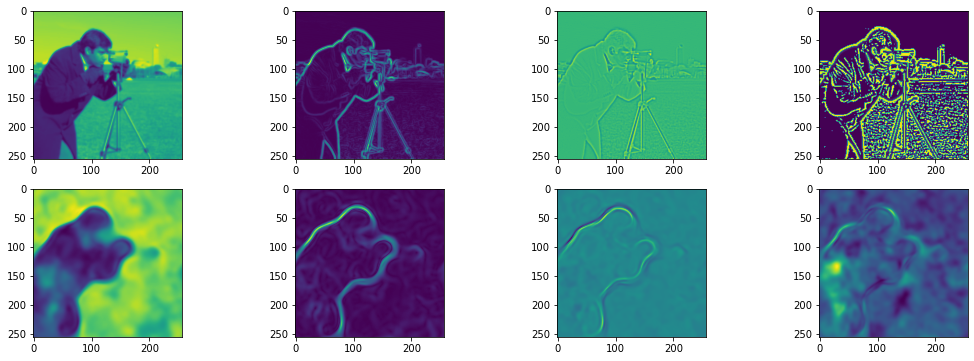

8it [00:40,  4.95s/it]

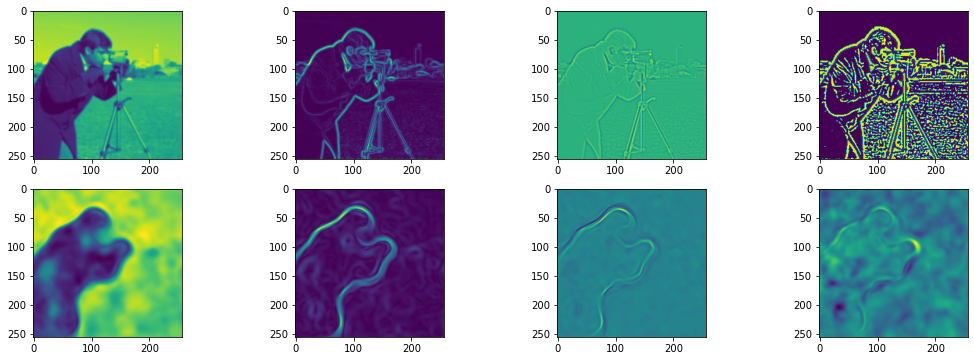

9it [00:45,  4.95s/it]

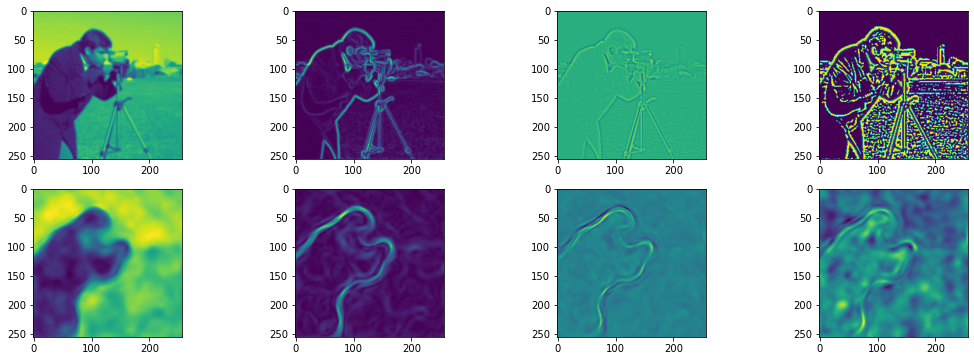

10it [00:49,  4.99s/it]


epoch 5, Epoch loss: total 0.059765, pixel 0.059765, grad 19.789108, laplacian 25782.782031, dIdt 17913.337988


10it [00:26,  2.66s/it]


epoch 6, Epoch loss: total 0.042986, pixel 0.042986, grad 17.908964, laplacian 32420.180273, dIdt 17913.724902


10it [00:25,  2.57s/it]


epoch 7, Epoch loss: total 0.046344, pixel 0.046344, grad 17.798767, laplacian 37221.292383, dIdt 17938.486426


10it [00:26,  2.62s/it]


epoch 8, Epoch loss: total 0.032501, pixel 0.032501, grad 20.292737, laplacian 45977.700977, dIdt 17911.483691


10it [00:26,  2.62s/it]


epoch 9, Epoch loss: total 0.029154, pixel 0.029154, grad 20.387836, laplacian 62781.623242, dIdt 17952.097363


0it [00:00, ?it/s]

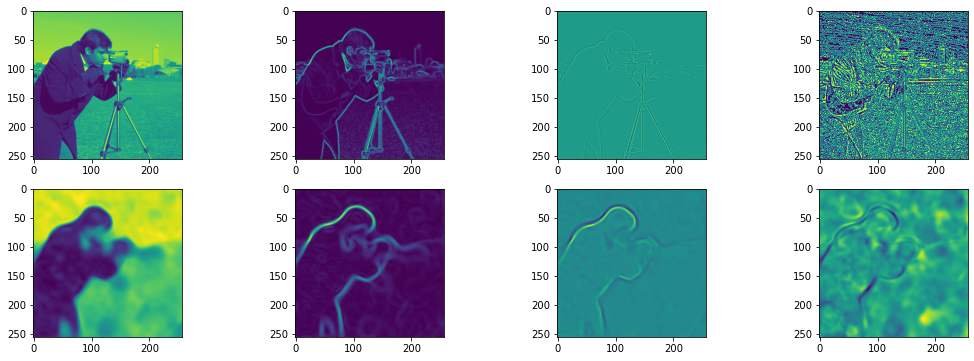

1it [00:04,  4.90s/it]

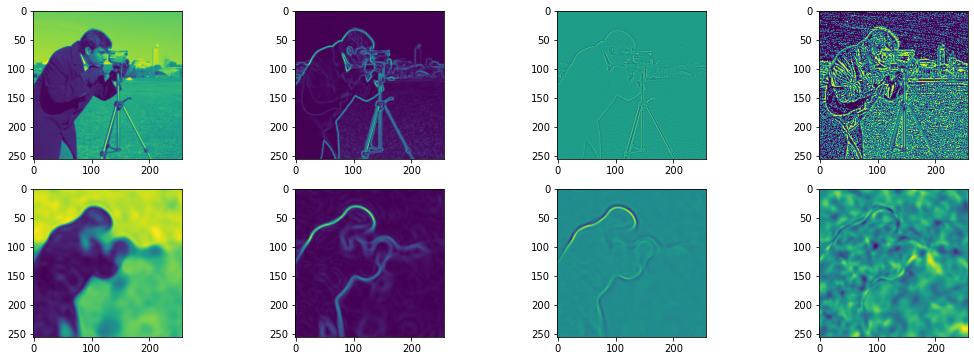

2it [00:09,  4.94s/it]

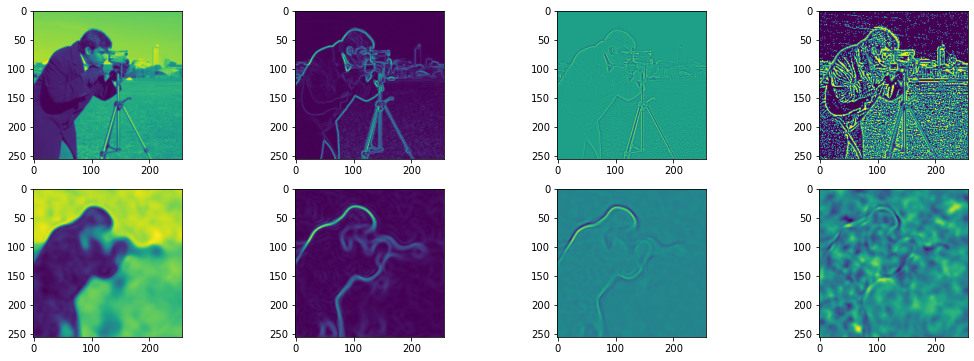

3it [00:14,  4.92s/it]

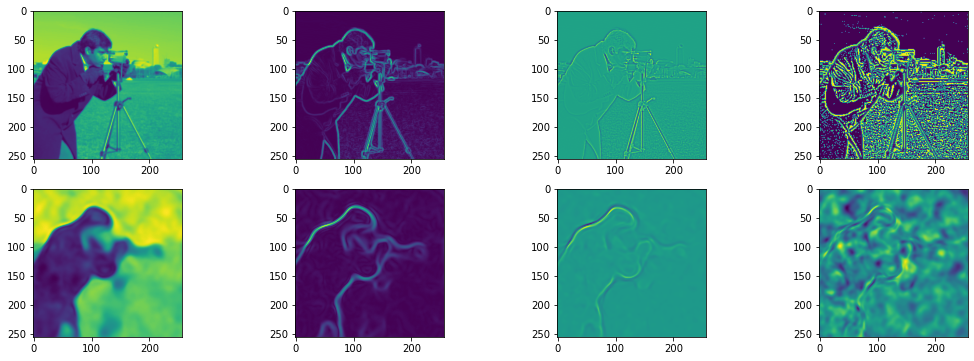

4it [00:19,  4.89s/it]

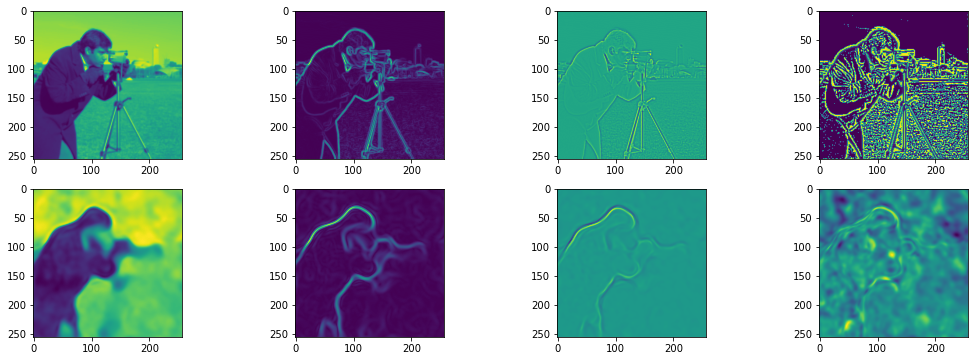

5it [00:24,  4.92s/it]

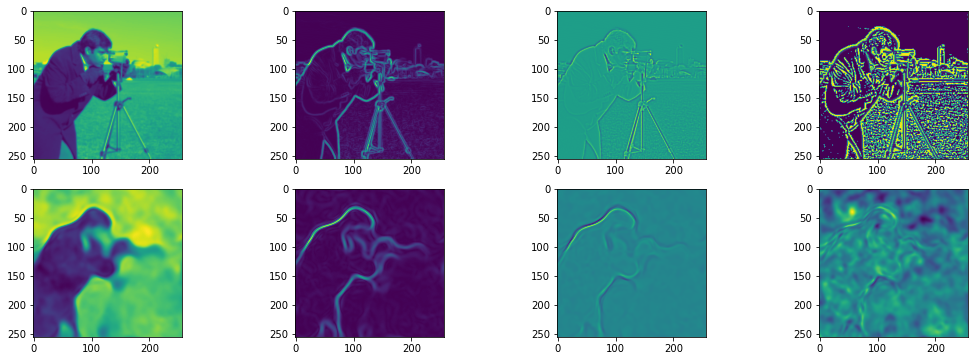

6it [00:29,  4.90s/it]

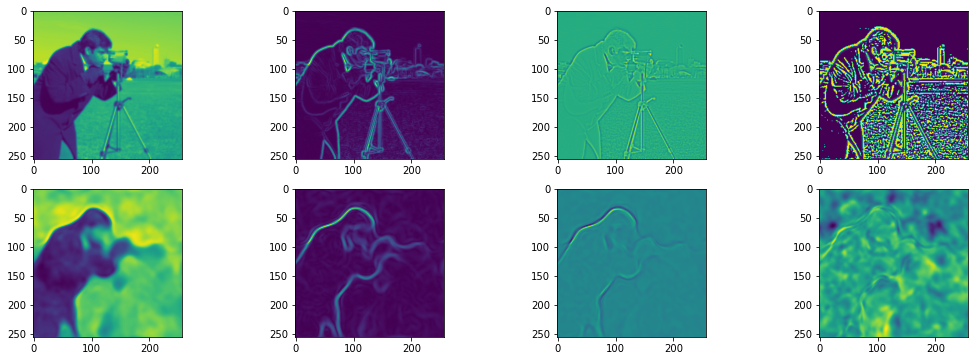

7it [00:34,  4.90s/it]

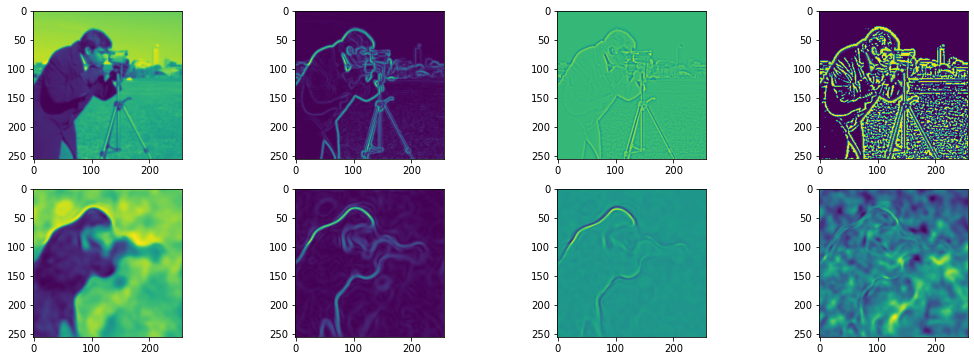

8it [00:39,  5.03s/it]

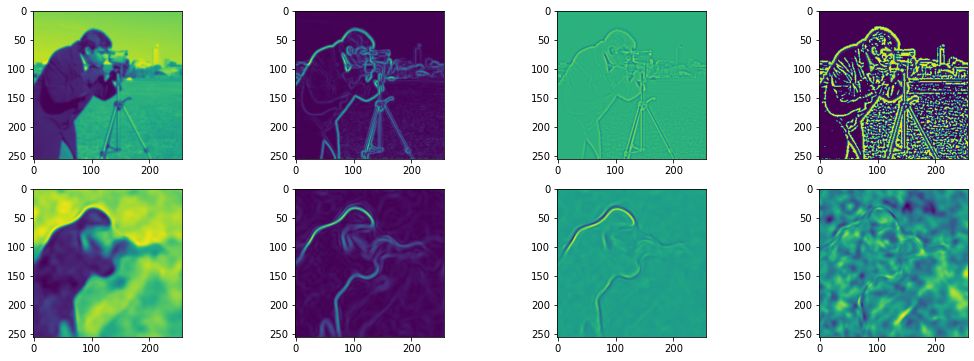

9it [00:44,  5.07s/it]

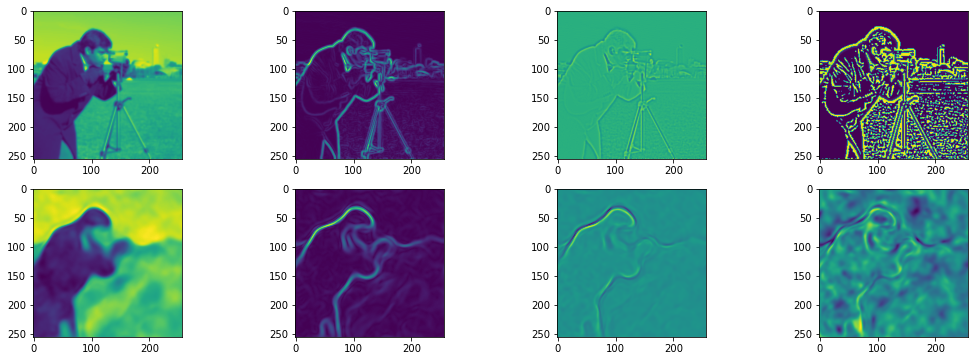

10it [00:49,  4.98s/it]


epoch 10, Epoch loss: total 0.029367, pixel 0.029367, grad 23.963778, laplacian 78596.461719, dIdt 17904.645898
-----Finished-----


In [33]:
# SIREN, learn only with the observed pixel values
writer = SummaryWriter('runs/siren/cameraman_experiment_pixels')

img_siren = Siren(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_siren, writer, img_path='original/cameraman.png', niter=10, total_epochs=10, beta_0=1, beta_1=0, beta_2=0, beta_3=0)

writer.close()

In [ ]:
# SIREN, learn only with the observed jacobians (first derivative in space)
writer = SummaryWriter('runs/siren/cameraman_experiment_grads')

img_siren = Siren(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_siren, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=0, beta_1=1, beta_2=0, beta_3=0)

writer.close()

In [ ]:
# SIREN, learns only with the observed laplacians (2nd derivative in space)
writer = SummaryWriter('runs/siren/cameraman_experiment_laplace')

img_siren = Siren(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_siren, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=0, beta_1=0, beta_2=1, beta_3=0)

writer.close()

In [ ]:
# SIREN, learn only with the observed derivative in time (3rd derivative)
writer = SummaryWriter('runs/siren/cameraman_experiment_dIdt')

img_siren = Siren(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_siren, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=0, beta_1=0, beta_2=0, beta_3=1)

writer.close()

In [ ]:
# SIREN, learn with all data, equally weighted
writer = SummaryWriter('runs/siren/cameraman_experiment_all')

img_siren = Siren(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_siren, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=1, beta_1=1, beta_2=1, beta_3=1, cyclic=True)

writer.close()

#### Elu Baselines

In [ ]:
# Base, learn only with the observed pixel values
writer = SummaryWriter('runs/base/cameraman_experiment_pixels')

img_base = Base(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_base, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=1, beta_1=0, beta_2=0, beta_3=0)

writer.close()

In [ ]:
# Base, learn only with the observed jacobians (first derivative in space)
writer = SummaryWriter('runs/base/cameraman_experiment_grads')

img_base = Base(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_base, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=0, beta_1=1, beta_2=0, beta_3=0)

writer.close()

In [ ]:
# Base, learn only with the observed laplacians (2nd derivative in space)
writer = SummaryWriter('runs/base/cameraman_experiment_laplace')

img_base = Base(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_base, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=0, beta_1=0, beta_2=1, beta_3=0)

writer.close()

In [ ]:
# Base, learn only with the observed derivative in time (3rd derivative)
writer = SummaryWriter('runs/base/cameraman_experiment_dIdt')

img_base = Base(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_base, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=0, beta_1=0, beta_2=0, beta_3=1)

writer.close()

In [ ]:
# Base, learn with all data, equally weighted
writer = SummaryWriter('runs/base/cameraman_experiment_all')

img_base = Base(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_base, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=1, beta_1=1, beta_2=1, beta_3=1)

writer.close()

### Experiments

#### Experiments Helper Functions

In [ ]:
# @min_beta_sum: minimum sum of all four beta values
# @return: a list of 4 beta values, summing to at least min_beta_sum
def generate_random_beta_combos(min_beta_sum=0.3):
    possible_values = [1.0, 0.1, 0.01, 0.001, 0.0]
    betas = [0, 0, 0, 0]
    
    while np.sum(betas) <= min_beta_sum:
        betas = [random.choice(possible_values) for i in range(4)]
        
    return betas

# @betas: a list of beta values
# @return: a string with '_' between all beta values
def b_to_string(betas):
    return '_'.join(map(str, betas))

In [ ]:
# runs one experiment with the elu activation function
def run_elu(model_path, betas, total_epochs, lr, cyclic=False, decay_exp=False, decay_multi=False):
    writer = SummaryWriter(model_path)
    
    img_base = Base(in_features=3, out_features=1, hidden_features=512, 
                    hidden_layers=3, outermost_linear=True)
    
    train(img_base, writer, img_path='original/cameraman.png', niter=10, 
          total_epochs=total_epochs, lr=lr,
          beta_0=betas[0], beta_1=betas[1], beta_2=betas[2], beta_3=betas[3], 
          cyclic=cyclic, decay_exp=decay_exp, decay_multi=decay_multi)
    
    writer.close()

In [ ]:
# runs one experiment with the SIREN (periodic) activation function
def run_siren(model_path, betas, total_epochs, lr, cyclic=False, decay_exp=False, decay_multi=False):
    writer = SummaryWriter(model_path)
    
    img_siren = Siren(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)
    
    train(img_siren, writer, img_path='original/cameraman.png', niter=10, 
          total_epochs=total_epochs, lr=lr,
          beta_0=betas[0], beta_1=betas[1], beta_2=betas[2], beta_3=betas[3], 
          cyclic=cyclic, decay_exp=decay_exp, decay_multi=decay_multi)
    
    writer.close()

#### Run the experiments

In [ ]:
# settings
model_path = 'runs/base/cameraman'
total_epochs = 10
learning_rates = [1e-4, 1e-5, 1e-6, 1e-7]

# keep conducting experiments until we've reached the desired amount
num_experiments = 0
while num_experiments < 1:
    
    # get a random combination of betas
    betas = generate_random_beta_combos()
    model_path += "/" + b_to_string(betas)
    
    ### Part A. Models with elu activation ###
    model_path_act = model_path + '/elu_'
    
    ## learning rate experiments ##
    
    # 1. run with uniform learning rates
    for uniform_lr in learning_rates:
        model_path_full = model_path_act + 'uniformlr_' + "{:.0e}".format(uniform_lr)
        run_elu(model_path_full, betas, total_epochs, [uniform_lr])
    
    # 2. run with decaying learning rates
    initial_lr = learning_rates[0]
    
    # 2.1 multi-step: decay_multi = True
    model_path_full = model_path_act + '_decay_multi_' + "{:.0e}".format(initial_lr)
    run_elu(model_path_full, betas, total_epochs, [initial_lr], decay_multi=True)
    
    # 2.2 exponential: decay_exp = True
    model_path_full = model_path_act + '_decay_exp_' + "{:.0e}".format(initial_lr)
    run_elu(model_path_full, betas, total_epochs, [initial_lr], decay_exp=True)
    
    # 3. run with cyclic learning rate
    max_lr = learning_rates[0]
    min_lr = learning_rates[-1]
    model_path_full = model_path_act + '_cyclic_' + "{:.0e}".format(max_lr) + "_" + "{:.0e}".format(min_lr)
    run_elu(model_path_full, betas, total_epochs, [max_lr, min_lr], cyclic=True)
    
    
    ### Part B. Models with SIREN (periodic) activation ###
    model_path_act = model_path + '/siren_'
    
    ## learning rate experiments ##
    
    # 1. run with uniform learning rates
    for uniform_lr in learning_rates:
        model_path_full = model_path_act + 'uniformlr_' + "{:.0e}".format(uniform_lr)
        run_siren(model_path_full, betas, total_epochs, [uniform_lr])
    
    # 2. run with decaying learning rates
    initial_lr = learning_rates[0]
    
    # 2.1 multi-step: decay_multi = True
    model_path_full = model_path_act + '_decay_multi_' + "{:.0e}".format(initial_lr)
    run_siren(model_path_full, betas, total_epochs, [initial_lr], decay_multi=True)
    
    # 2.2 exponential: decay_exp = True
    model_path_full = model_path_act + '_decay_exp_' + "{:.0e}".format(initial_lr)
    run_siren(model_path_full, betas, total_epochs, [initial_lr], decay_exp=True)
    
    # 3. run with cyclic learning rate
    max_lr = learning_rates[0]
    min_lr = learning_rates[-1]
    model_path_full = model_path_act + '_cyclic_' + "{:.0e}".format(max_lr) + "_" + "{:.0e}".format(min_lr)
    run_siren(model_path_full, betas, total_epochs, [max_lr, min_lr], cyclic=True)
    
    
    # finished one more experiment
    num_experiments += 1

### Visualize Results

In [35]:
%load_ext tensorboard
%tensorboard --logdir="runs"

In [ ]:
import shutil
import subprocess

def output_video(net, img_path, niter, vidName='video_name.mp4'):

    image = ImageFitting(img_path=img_path, niter=niter)
    dataloader = DataLoader(image, batch_size=1, pin_memory=True, num_workers=0)

    net.cuda()
    
    if os.path.exists("tmp"):
        shutil.rmtree("tmp")
    os.makedirs("tmp")

    for step, batch in tqdm(enumerate(dataloader)):
        
        model_input = batch[0].cuda()
        gt = {key: value.cuda() for key, value in batch[1].items()}

        model_output, coords = net(model_input)
        img_grad = computeJacobianFull(coords, model_output, create_graph=True)
        img_laplacian = computeLaplaceFull(coords, img_grad, create_graph=False)

        fig, axes = plt.subplots(2,4, figsize=(18,6))
        axes[0,0].imshow(gt['pixels'][0].cpu().view(256,256).detach().numpy())
        axes[0,1].imshow(gt['grads'][0].norm(dim=-1).cpu().view(256,256).detach().numpy())
        axes[0,2].imshow(gt['laplace'][0].cpu().view(256,256).detach().numpy())
        axes[0,3].imshow(gt['dIdt'][0].cpu().view(256,256).detach().numpy())
        axes[1,0].imshow(model_output[0].cpu().view(256,256).detach().numpy())
        axes[1,1].imshow(img_grad[0][:,:-1].norm(dim=-1).cpu().view(256,256).detach().numpy())
        axes[1,2].imshow(img_laplacian[0].cpu().view(256,256).detach().numpy())
        axes[1,3].imshow(img_grad[0][:,-1].cpu().view(256,256).detach().numpy())
        
        fig.savefig("tmp/file%02d.png" % step)

    
    subprocess.call([
        'ffmpeg', '-framerate', '2', '-i', 'tmp/file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        vidName
    ])
    
    shutil.rmtree("tmp")